In [1]:
# Import plotting tools
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [37]:
# Import stats and analystical toos
import numpy as np
from scipy import stats


In [3]:
# Import other tools
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# View Masurement table columns
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f358a508d0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
# View Station table columns
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f358a8a080>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1}

# Exploratory Climate Analysis

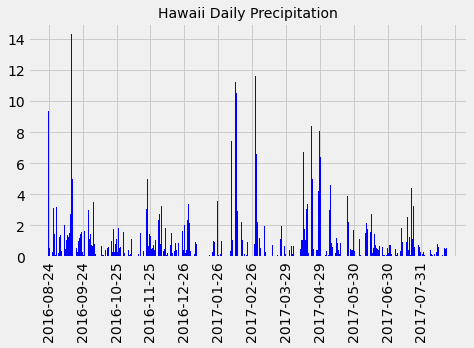

In [12]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#session.query(Measurement.date).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).count()

# Perform a query to retrieve the data and precipitation scores
from sqlalchemy.sql import func
sel = [func.sum(Measurement.prcp), Measurement.date]

rainfall = session.query(*sel).\
    order_by(Measurement.date).\
    filter(Measurement.date >= '2016-08-24').\
    group_by(Measurement.date).all()
rainfall

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(rainfall, columns=["Precipitation", "Date"]).set_index("Date")
df.head(50)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(7,4))
plt.xticks(rotation=90)
plt.title("Hawaii Daily Precipitation", fontsize=14)
ax.bar(df.index, df["Precipitation"], color="b")
ax.xaxis.set_major_locator(ticker.MultipleLocator(31))


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [14]:
# Design a query to show how many stations are available in this dataset?

# Simple queries on Station database returns 9 unique stations
session.query(Station.station).all()
session.query(Station.station).count()

# Confirm results by using groupby function in Measurement databse; also returns 9 stations
session.query(Measurement.station).group_by(Measurement.station).all()
session.query(Measurement.station).group_by(Measurement.station).count()


9

In [15]:
## What are the most active stations? (i.e. what stations have the most rows)?
# Use count function on tempurature observations to determine overall activity
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).all()
active_stations

# List the stations and the counts in descending order.
pd.DataFrame(active_stations, columns=["Stations", "Total TOBS"]).sort_values(by="Total TOBS", ascending=False)


,Stations,Total TOBS
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

low_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()
low_temp

high_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()
high_temp

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()
avg_temp

print(high_temp, low_temp, avg_temp)

[('USC00519281', 85.0)] [('USC00519281', 54.0)] [('USC00519281', 71.66378066378067)]


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

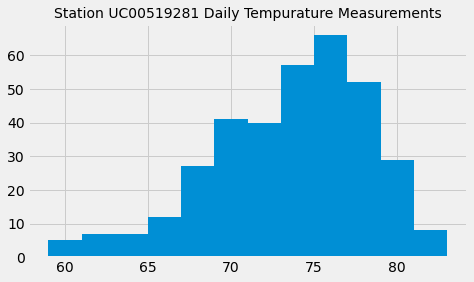

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
temps = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= '2016-08-24').all()

df1 = pd.DataFrame(temps, columns=["Daily Temp"])

# Plot results as a histogram
fig, ax = plt.subplots(figsize=(7,4))
plt.title("Station UC00519281 Daily Tempurature Measurements", fontsize=14)
ax.hist(df1["Daily Temp"], bins=12)




## Bonus Challenge Assignment

In [ ]:
## NOTE:  The bonus assignment code included in the starter file didn't appear to match the Readme file included
        # with this week's homework assignment.  The following sections following the Readme file assignment,
        # followed at the end by the completion of any extra coding blocks that weren't used.

In [206]:
## Tempurature Analysis I Challenge

# Identify the averate tempurate in June at all stations across all available years:
jun_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "06").all()
jun_avg = "%4.2f" % jun_avg[0]

# Identify the averate tempurate in Decmeber at all stations across all available years:
dec_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "12").all()
dec_avg = "%4.2f" % dec_avg[0]

# Use a t-test to determine whether the difference is statistically significant (NOTE:  Am using an unpaired test
# as the samples compare tempuratures across two different months or seasons, rather than comparing tempurature
# variations in the same month over a period of years)
jun_all = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
dec_all = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()
ttest = stats.ttest_ind(jun_all, dec_all)

print("Jun Avg:", jun_avg, "Dec Avg:", dec_avg)
ttest



Jun Avg: 74.94 Dec Avg: 71.04


Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

Text(0.5, 1.0, 'Trip Average Tempurature:  12/23/16- 01/06/17')

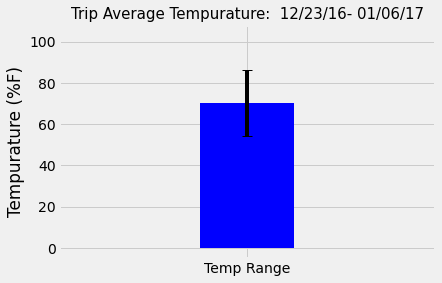

In [159]:
## Tempurate Analysis II Challenge

# Calculate the min, avg, and max tempuratures for a selected two week trip period using the calc temp function
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Create chart data
temps = calc_temps("2016-12-23", "2017-01-06")
tmin = temps[0][0]
tavg = temps[0][1]
tmax = temps[0][2]
error = tmax-tmin
x_axis = np.arange(1)

# Plot chart values
fig, ax = plt.subplots()
ax.bar("Temp Range", tavg, color="b", width=0.5, yerr=error, align='center', ecolor='black', capsize=5)
ax.set_ylabel("Tempurature (%F)")

plt.xlim(-1, +1)
plt.ylim(-5, tmax+30)
# ax.set_xticks(1)

ax.set_title("Trip Average Tempurature:  12/23/16- 01/06/17", fontsize=15)
#ax.yaxis.grid(True)


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2016-08-24', '2017-08-23'))


[(58.0, 74.57894736842105, 87.0)]


In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [369]:
## Daily Rainfall Average Challenge - Part I
# Calculate the total amount of rainfall per weather station for your trip using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Query data
trip_precip = session.query(Measurement.station, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= "2016-12-23").\
    filter(Measurement.date <= "2017-01-06").\
    group_by(Measurement.station).all()

station_info = session.query(Station.station, Station.name, Station.latitude, 
                             Station.longitude, Station.elevation).all()

# Create dataframes for each query; first separate data into lists and then assemble dataframes
# Rainfall datafram
station_list=[]
rainfall_list=[]
for item in trip_precip:
    station_list.append(item[0])
    rainfall_list.append(item[1])
    
rainfall_df = pd.DataFrame({"Avg. Precip": rainfall_list}, station_list)

# Station info dataframe
station1_list =[]
name_list =[]
lat_list = []
long_list =[]
elev_list=[]
for item in station_info:
    station1_list.append(item[0])
    name_list.append(item[1])
    lat_list.append(item[2])
    long_list.append(item[3])
    elev_list.append(item[4])

input = {"Name": name_list, "Latitude": lat_list, "Longitude": long_list, "Elevation": elev_list}
station_df = pd.DataFrame(input, station1_list)

# Merge dataframes
Output_df = pd.concat([station_df, rainfall_df], axis=1)
Output_df.sort_values(by=["Avg. Precip"])

,Name,Latitude,Longitude,Elevation,Avg. Precip
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.23
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.93
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.95
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.00
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.08
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,8.95
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN


In [ ]:
# Try reproducing above analysis with a simpler, joined query using SQL Alchemy



In [370]:
## Daily Rainfall Average Challenge - Part II

# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("12-23")

[(61.0, 70.34693877551021, 78.0)]

In [421]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
Start_date = dt.date(2016, 12, 23)
End_date = dt.date(2017, 1, 6)

# Use the start and end date to create a range of dates


# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

Date = Start_date

date_list=[]
tmin_list=[]
tavg_list=[]
tmax_list=[]

while Date <= End_date:
    date_string = Date.strftime("%m-%d")
    
    date_list.append(Date)
    
    # Calculate and store tmin
    tmin = session.query(func.min(Measurement.tobs).\
                         filter(func.strftime("%m-%d", Measurement.date) == date_string)).all()
    tmin_list.append("%4.2f" % tmin[0])
    
    # Calculate and store tavg
    tavg = session.query(func.avg(Measurement.tobs).\
                         filter(func.strftime("%m-%d", Measurement.date) == date_string)).all()
    tavg_list.append("%4.2f" % tavg[0])
    
    # Calculate and store tmax
    tmax = session.query(func.max(Measurement.tobs).\
                         filter(func.strftime("%m-%d", Measurement.date) == date_string)).all()
    tmax_list.append("%4.2f" % tmax[0])
    
    # Print each row to check output
    # print(Date, tmin[0], tavg[0], tmax[0])
    
    # Step "Date" by 1 day
    Date += dt.timedelta(days=1)


In [498]:
# Store data in dataframe
daily_input = {"Daily Min": tmin_list, "Daily Avg": tavg_list, "Daily Max": tmax_list}
daily_norms_df = pd.DataFrame(daily_input, date_list)
daily_norms_df.head()

,Daily Min,Daily Avg,Daily Max
2016-12-23,61.00,70.35,78.00
2016-12-24,62.00,70.06,78.00
2016-12-25,60.00,71.75,79.00
2016-12-26,63.00,71.45,77.00
2016-12-27,62.00,71.92,79.00


(array([736320., 736321., 736322., 736323., 736324., 736325., 736326.,
        736327., 736328., 736329., 736330., 736331., 736332., 736333.,
        736334., 736335., 736336.]),
 <a list of 17 Text major ticklabel objects>)

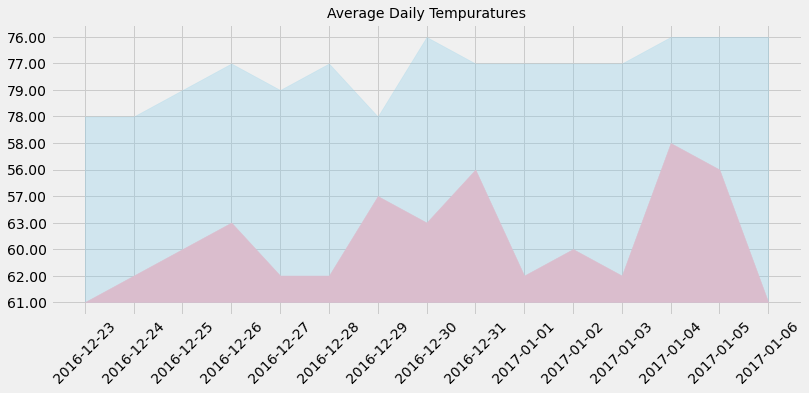

In [500]:
# Plot daily norms (Note:  Aveerage values, while displayed corretly in dataframe, would only plot as a straighline
    # on the chart, which is incorrect.  Was unable to determine erros and thus removed from chart)

fig, ax = plt.subplots(figsize=(12,5))
x_axis=daily_norms_df.index

#ax.set_ylim(55, 90)
plt.fill_between(x_axis, daily_norms_df["Daily Min"], color="lightpink", alpha=1)
# plt.fill_between(x_axis, daily_norms_df["Daily Avg"], color="lightgreen", alpha=0.5)
plt.fill_between(x_axis, daily_norms_df["Daily Max"], color="skyblue", alpha=0.3)
plt.title("Average Daily Tempuratures", fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=45)
           


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
